It is a pain to have to keep dumping compute and garbage text files just to regenerate J each time.
The point of this notebook is to carefully review the process of J calculation,
so that we can perform it just once and save to the result to a shared numpy zip file.

In [1]:
%matplotlib notebook
import flux

Missing flux value for: GLEAM J202818-254302 at frequency: 204 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 212 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 220 MHz.
Missing flux value for: GLEAM J202818-254302 at frequency: 227 MHz.
Missing spectral index for: GLEAM J202818-254302


//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.pos1_Elm_samples = h5f["pos1_Elm"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.neg1_Elm_samples = h5f["neg1_Elm"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:20: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.freq_nodes = h5f["frequencies"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.L_model = h5f["spatial_bandlimit"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:22: H5pyDeprec

delta_nu_in is 1000000.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [3]:
list_az = []
list_alt = []
for source in flux.catalog.obj_catalog:
    ra = np.radians(source.ra_angle)
    dec = np.radians(source.dec_angle)
    az, alt = flux.rot.eq_to_topo(
        ra, dec,
        np.radians(flux.rot.hera_lat),
        flux.rot.get_lst(), radians=True
    )
    list_az.append(az)
    list_alt.append(alt)

In [4]:
# reformat into arrays so that the spline function can handle the single angles
list_az = np.array(list_az)
list_alt = np.array(list_alt)
print(list_az)
print(list_alt)

[-2.49392327  2.45052987  3.12676636 ...  1.73038089  3.06607766
  1.95999999]
[ 1.51577329 -0.14064867 -0.62208971 ...  0.82095196 -0.65339114
  0.71536525]


In [5]:
#nside = 16, 32, 64, 128...
nside = 128

# healpix does the interpolation for you?
theta, phi = hp.pix2ang(nside, np.arange(12 * nside * nside))
az = phi
alt = np.pi / 2 - theta
J = flux.stokes.spline_beam_func(150e6, alt, az)

In [6]:
J = flux.stokes.spline_beam_func(150e6, list_alt, list_az)
J.shape

(3872, 2, 2)

In [7]:
empty_blocks = 0
for block in J:
    if block[0][0] == 0 and \
        block[1][0] == 0 and \
        block[0][1] == 0 and \
        block[1][1] == 0:
        empty_blocks += 1
empty_blocks

1517

In [8]:
""" This is a major problem, is it not? """
percent_empty = 100 * empty_blocks / len(J)
percent_empty

39.178719008264466

In [19]:
def rad_interp(J_section, ra, dec, lst):
    """
    Abbreviation and conversion function. We get the interpolation value
    assuming @az and @alt are in degrees.
    """
    az, alt = flux.rot.eq_to_topo(ra, dec, latitude=np.radians(flux.rot.hera_lat), lst=lst, radians=True)
    colatitude = np.radians(90 - alt)
    longitude = np.radians(az)
    return hp.get_interp_val(J_section, colatitude, longitude)

In [20]:
# Hard-coding a right-ascension,
# this should be a maximum response...

# the cold patch represents degrees 0 through 120

ra_max = np.radians(59.984791666666666)
dec_max = np.radians(-23.4345)

J_max = flux.stokes.J_matrix(ra, dec, lst=np.pi / 3)
print(J_max)
print(rad_interp(J_max, ra_max, dec_max, np.pi / 3))

[[[-0.01169484+0.00335301j -0.05251387-0.01053338j]
  [-0.0521776 +0.0101595j   0.01215581+0.00316631j]]]


ValueError: Wrong pixel number (it is not 12*nside**2)


Declination (degrees): -30.72 
Right acension (degrees): 0 
Resultant J matrix:
 [[[-0.01394893+0.00664088j  0.03292649+0.00266418j]
  [ 0.01151518-0.03048613j  0.01611135-0.01044008j]]] 


Declination (degrees): -30.72 
Right acension (degrees): 10 
Resultant J matrix:
 [[[-0.00941275+0.00865026j  0.02039517-0.0150796j ]
  [ 0.01680992-0.02457134j  0.00893044-0.01070789j]]] 


Declination (degrees): -30.72 
Right acension (degrees): 20 
Resultant J matrix:
 [[[ 0.01164934+0.00730785j -0.02650823-0.02985053j]
  [-0.03844987-0.01168298j -0.01436482-0.00873063j]]] 


Declination (degrees): -30.72 
Right acension (degrees): 30 
Resultant J matrix:
 [[[ 0.00480075+0.00541987j -0.01722691-0.02081558j]
  [-0.02089781-0.02192923j -0.00578392-0.00637318j]]] 


Declination (degrees): -30.72 
Right acension (degrees): 40 
Resultant J matrix:
 [[[ 0.01085977+0.00071735j -0.05349354-0.01452555j]
  [-0.06220647+0.01857443j -0.01114586+0.00174292j]]] 


Declination (degrees): -30.72 
Right acension

<IPython.core.display.Javascript object>


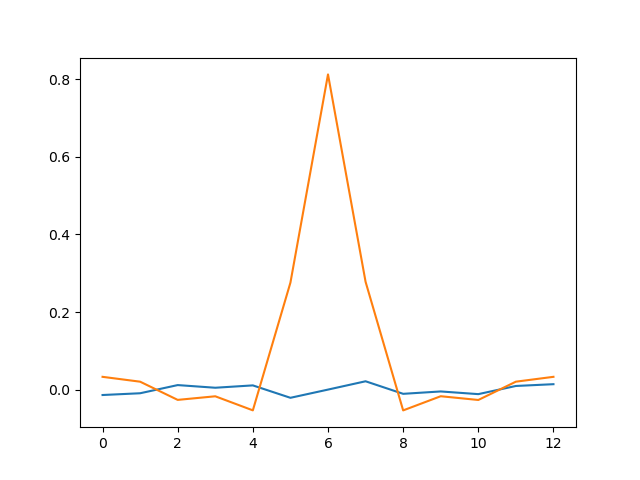

//anaconda3/envs/hera/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [22]:
dec_decf = np.radians(-30.72)

ra_decf = 0

first_term = []

while ra_decf <= 120:
    J_decf = flux.stokes.J_matrix(
        np.radians(ra_decf), dec_decf, lst=np.pi / 3
    )
    print("\nDeclination (degrees):", np.around(np.degrees(dec_decf), 2),
          "\nRight acension (degrees):", np.around(ra_decf, 2),
          "\nResultant J matrix:\n", J_decf, "\n")
    first_term.append(J_decf[0][0])
    ra_decf += 10
plt.plot(np.array(first_term))

In [11]:
dec_raf = -40.72

ra_raf = np.radians(59.984791666666666)

first_term = []

while dec_raf <= -20.72:
    J_raf = flux.stokes.J_matrix(
        ra_raf, np.radians(dec_raf), lst=np.pi / 3
    )
    print("\nDeclination (degrees):", np.around(dec_decf, 2),
          "\nRight acension (degrees):", np.around(np.degrees(ra_decf), 2),
          "\nResultant J matrix:\n", J_raf, "\n")
    first_term.append(J_raf[0][0])
    dec_raf += 5
plt.plot(np.array(first_term))


Declination (degrees): -0.54 
Right acension (degrees): 7448.45 
Resultant J matrix:
 [[[1.03084029e-03+1.71170084e-03j 8.60120039e-02-8.93682447e-02j]
  [1.69007584e-01-1.67573766e-01j 1.18433426e-04-8.24630327e-05j]]] 


Declination (degrees): -0.54 
Right acension (degrees): 7448.45 
Resultant J matrix:
 [[[1.27856918e-03+1.80730298e-03j 5.40772527e-01-3.97594659e-01j]
  [5.83984880e-01-4.34414825e-01j 1.73553521e-04-1.31898261e-04j]]] 


Declination (degrees): -0.54 
Right acension (degrees): 7448.45 
Resultant J matrix:
 [[[-8.19603320e-05+1.10584657e-04j  8.12623651e-01-5.82785131e-01j]
  [ 8.12623351e-01-5.82784739e-01j  8.19473175e-05-1.10462013e-04j]]] 


Declination (degrees): -0.54 
Right acension (degrees): 7448.45 
Resultant J matrix:
 [[[-1.39479011e-03-1.64909938e-03j  5.40511315e-01-3.97418380e-01j]
  [ 5.86165859e-01-4.30790059e-01j -5.74351505e-05-1.45552748e-05j]]] 


Declination (degrees): -0.54 
Right acension (degrees): 7448.45 
Resultant J matrix:
 [[[-1.0584918